<a href="https://colab.research.google.com/github/Carlo-pien/Projet_ML_2_MA1/blob/master/pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Dec 20 16:02:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    61W / 149W |   1456MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install einops
!pip install pytorch-lightning
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

     |████████████████████████████████| 526 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 41.7 MB/s 
     |████████████████████████████████| 829 kB 41.7 MB/s 
     |████████████████████████████████| 132 kB 48.1 MB/s 
     |████████████████████████████████| 332 kB 48.9 MB/s 
     |████████████████████████████████| 1.1 MB 35.9 MB/s 
     |████████████████████████████████| 192 kB 45.5 MB/s 
     |████████████████████████████████| 271 kB 40.5 MB/s 
     |████████████████████████████████| 160 kB 55.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=1b867bb18997b48f1962bc5ffad0ae763332e59902b5a6e8f1870e2466daef7c
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

Importing the relevant packages

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import numpy as np
import math
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms as transforms
import albumentations.augmentations.transforms as tf
from torchvision.transforms import Compose
import torchvision.transforms.functional as TF
from einops import rearrange, reduce
import pytorch_lightning as pl
import cv2
import segmentation_models_pytorch as smp
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")
import albumentations as album

Creating helper functions for image preprocessing and visualization

In [ ]:
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map


def to_RGB(mask):
  return np.repeat(np.round(mask)[:, :, np.newaxis], 3, axis=2)


def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.numpy().astype(int)]

    return x

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

Provided functions for loading the data

In [ ]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

Loading the training data

In [ ]:
root_dir = "/content/drive/MyDrive/Projet_ML/training/"

n = 100
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(n, len(files))
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

data = []
for idx, img in enumerate(imgs) :
  data.append(img)

labels = []
for idx, mask in enumerate(gt_imgs) :
  labels.append(mask)

Loading 100 images
Loading 100 images


Just a cell for testing transformations, no need to run

Text(0.5, 1.0, 'Image compression')

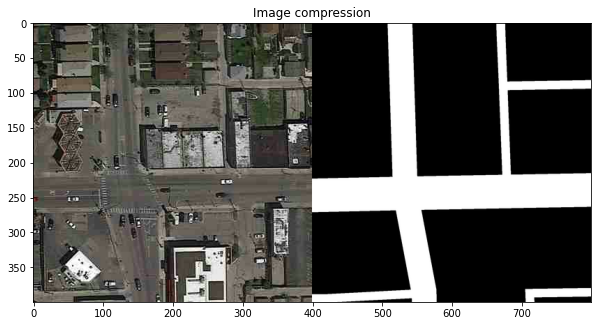

In [ ]:
"""aug = album.augmentations.ImageCompression(quality_lower=20, quality_upper=21, p=1.)

x = data[0]
y = labels[0]

out = aug(image = x, mask = y)

cimg = concatenate_images(out['image'], out['mask'])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')
plt.title("Image compression")
"""

Creating a custom pytorch dataset class

In [ ]:
class RoadsDataset(torch.utils.data.Dataset):

    def __init__(
            self, 
            data = data,
            labels = labels,
            class_rgb_values=[[255, 255, 255], [0, 0, 0]], 
            augmentation=None, 
            preprocessing=None,
    ):

        self.image_ = data
        self.mask_ = labels
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = np.array(self.image_)[i,:,:,:]
        mask = np.array(self.mask_)[i,:,:]
        
        # one-hot-encode the mask
        mask = to_RGB(mask)
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

            
        return image, mask
    
    def __len__(self):
        # return length of 
        return np.array(data).shape[0]

'''Defining the transformations
We can comment the different transformation we don't want to use for the training of our model. 
Here, we set the transformations that gave us the best f1 score using our pretrained model.
You can have a look at the effect of these transformations on the final report of our project.'''
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.RandomSizedCrop(min_max_height=	[200,200], height = 400, width=400, p = 0.5),
        album.ShiftScaleRotate(p=0.5),
        album.Affine(shear=[-10, 10], scale=1.1, fit_output=False, p=.1),
        album.GaussNoise(var_limit=(.001, .03), p=.5),
        album.Blur(blur_limit=5., p=.2),
        album.ImageCompression(quality_lower=50, p=.2),
    ]
    return album.Compose(train_transform)

Loading the data in the dataset, and creating a dataloader

In [ ]:
dataset = RoadsDataset(data, labels, augmentation=get_training_augmentation(), preprocessing=get_preprocessing())
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

## Model :


Downloading a pretrained model

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'road']
ACTIVATION = 'sigmoid'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Setting the relevant hyperparameters for training, and defining the training step

In [ ]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 500 #Can be change to train different model. Here we set the number of epochs which gave use the best f1 score with this model


# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

### Model Training

The model parameters are saved every 3 training epochs, so the model can be tested at several steps of its training and the best performing one can be chosen for submission. This is intended to mimic early stopping.

In [ ]:
#%%time
sys.path.append('/content/drive/MyDrive/Projet_ML/')
model.train()
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(dataloader)
        #valid_logs = valid_epoch.run(valid_loader
        train_logs_list.append(train_logs)
        #valid_logs_list.append(valid_logs)

        # Save model if every 6 training epochs
        if i % 400 == 0 and i != 0 :
            torch.save(model, '/content/drive/MyDrive/Projet_ML/pretrained_models/deeplabv3p_300_epochs_arthur.pth'.format(i))

path = os.path.join('/content/drive/MyDrive/Projet_ML/pretrained_models/deeplabv3p_300_epochs_arthur.pth') #to be changed if we run another model
torch.save(model, path)


Epoch: 0
train: 100%|██████████| 7/7 [00:22<00:00,  3.28s/it, dice_loss - 0.5311, iou_score - 0.4095]

Epoch: 1
train: 100%|██████████| 7/7 [00:22<00:00,  3.27s/it, dice_loss - 0.4812, iou_score - 0.5661]

Epoch: 2
train: 100%|██████████| 7/7 [00:25<00:00,  3.71s/it, dice_loss - 0.435, iou_score - 0.6499]

Epoch: 3
train: 100%|██████████| 7/7 [00:22<00:00,  3.16s/it, dice_loss - 0.3992, iou_score - 0.7123]

Epoch: 4
train: 100%|██████████| 7/7 [00:22<00:00,  3.21s/it, dice_loss - 0.3712, iou_score - 0.7564]

Epoch: 5
train: 100%|██████████| 7/7 [00:22<00:00,  3.18s/it, dice_loss - 0.3472, iou_score - 0.7919]

Epoch: 6
train: 100%|██████████| 7/7 [00:23<00:00,  3.32s/it, dice_loss - 0.3241, iou_score - 0.8214]

Epoch: 7
train: 100%|██████████| 7/7 [00:22<00:00,  3.22s/it, dice_loss - 0.3097, iou_score - 0.8282]

Epoch: 8
train: 100%|██████████| 7/7 [00:22<00:00,  3.20s/it, dice_loss - 0.2909, iou_score - 0.8484]

Epoch: 9
train: 100%|██████████| 7/7 [00:22<00:00,  3.21s/it, dice_loss -

In [ ]:
model.eval()

Visualizing the outpout of the model on some training image, alongside the relevant image and the corresponding mask

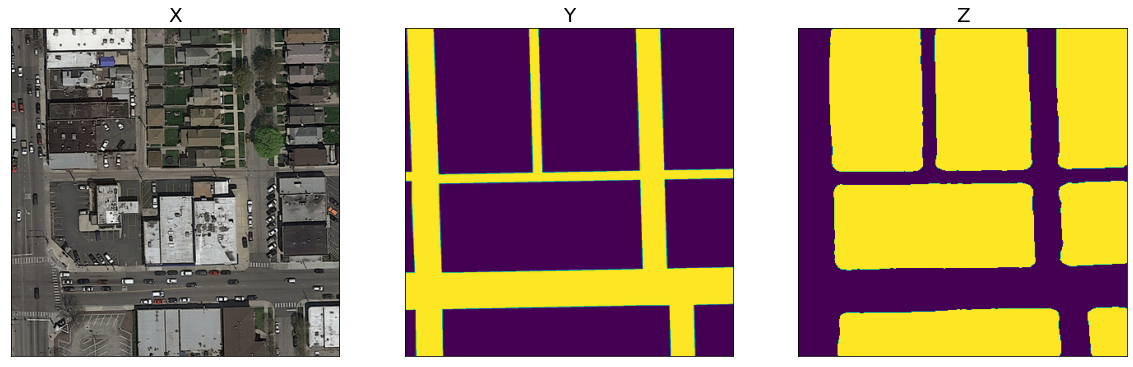

In [ ]:
x = data[13]
y = labels[13]

visualize(
    x=x,
    y=y,
    z = model(torch.tensor(np.expand_dims(x, 0).transpose(0, 3, 1, 2)).to('cuda')).detach().cpu().numpy()[0][1]>0.99
)

## Predictions

Loading the test set. Test images are resized to the 400 by 400 format of the training images

In [ ]:
test_aug_downsize = album.RandomSizedCrop(min_max_height=	[608,608], height = 400, width=400, p = 1.)

root_dir_test = "/content/drive/MyDrive/Projet_ML/test_set_images/"
n_test = 50
files_test = os.listdir(root_dir_test)
files_test = [file for file in files_test if file.endswith('.png')]
n_test = min(n_test, len(files_test))
imgs_test = []
imgs_test_names = []
for i in range(n_test):
  imgs_test.append(test_aug_downsize(image=load_image(root_dir_test + files_test[i])))
  img_name = str(files_test[i])
  img_name = img_name.replace("test_", "")
  img_name = img_name.replace(".png", "")
  img_name = img_name.zfill(2)
  imgs_test_names.append(img_name)

Testing whether resize worked as expected :

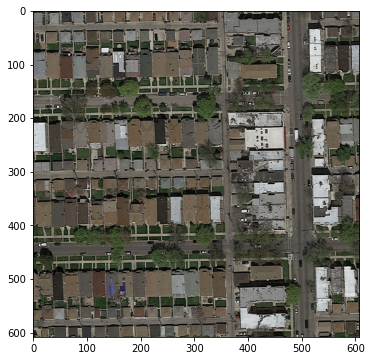

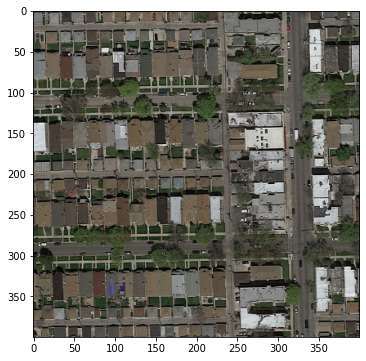

In [ ]:
files_test = os.listdir(root_dir_test)
files_test = [file for file in files_test if file.endswith('.png')]
im = load_image(root_dir_test + files_test[0])
resized = test_aug_downsize(image=load_image(root_dir_test + files_test[0]))

fig1 = plt.figure(figsize=(6, 6))
plt.imshow(im, cmap='Greys_r')

fig1 = plt.figure(figsize=(6, 6))
plt.imshow(resized['image'], cmap='Greys_r')

Reloading the model (this is usefull if the runtime was stopped/restared after training, which might be necessary to save cuda memory)

In [ ]:
path = os.path.join('/content/drive/MyDrive/Projet_ML/pretrained_models/deeplabv3p_500_epochs.pth') #insert path to relevant model
model = torch.load(path)
model.eval()

Generating predictions and storing the predicted masks in a list

In [ ]:
test_aug_upsize = album.RandomSizedCrop(min_max_height=	[400,400], height = 608, width=608, p = 1.)

preds = []
for i in range(n_test):
  y = model(rearrange(torch.unsqueeze(torch.Tensor(imgs_test[i]['image']), dim=0), 'b h w c -> b c h w').to('cuda'))
  y = rearrange(torch.squeeze(y, dim=0).to('cpu').detach().numpy(), 'c h w -> h w c')
  y = test_aug_upsize(image=y)
  preds.append(y)

Visualizing the predicted masks for test images

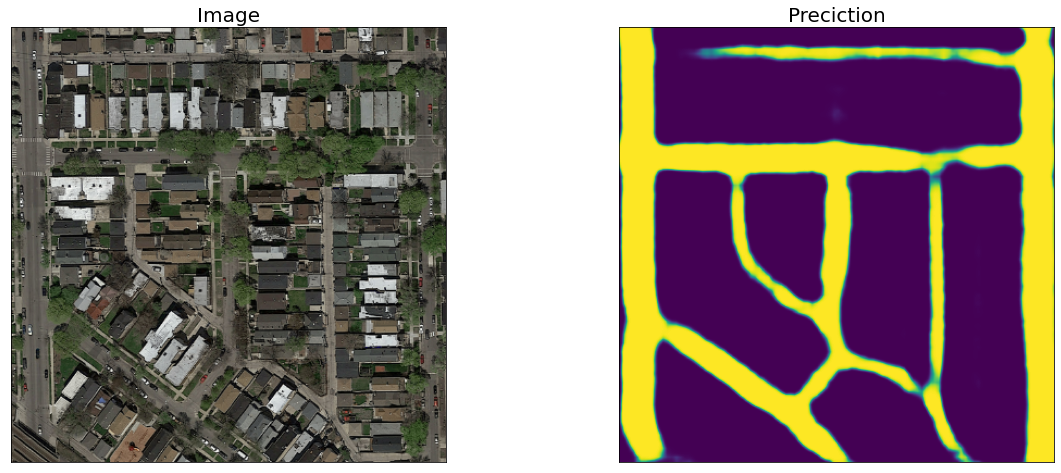

In [ ]:
#y = 1-(preds[25]['image'].transpose(2, 0, 1)[1])>0.5
y = 1-(preds[36]['image'].transpose(2, 0, 1)[1])
visualize(
    image=imgs_test[35]['image'],
    preciction= y
)

Creating a new list with only the relevant part of the masks (that is, the masks are dictionaries, so we evaluate them to get only the keys associated to the masks. 

In [ ]:
for_submission = []
for i, pred in enumerate(preds) :
  #for_submission.append(1-(preds[i]['image'].transpose(2, 0, 1)[1])>0.8) #This line is here if we want to use a threshold for our classification.
  for_submission.append(1-(preds[i]['image'].transpose(2, 0, 1)[1]))

Saving the masks in a new directory

In [ ]:
from PIL import Image as im
path = os.path.join('/content/drive/MyDrive/Projet_ML/for_submission/')

for i, mask in enumerate(for_submission):
  name = imgs_test_names[i]
  mask = im.fromarray(255*mask)
  mask = mask.convert('RGB')
  mask.save(path+name+'.png')

Creating a submission csv file

In [ ]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    #if df > foreground_threshold:
    if df < foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            #label = patch_to_label(patch)
            label = 1-patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


def create_submission():
  submission_filename = '/content/drive/MyDrive/Projet_ML/twenty_first_submission.csv'
  image_filenames = []
  for i in range(1, 51):
      image_filename = '/content/drive/MyDrive/Projet_ML/for_submission/' + '%.2d' % i + '.png'
      #print(image_filename)
      image_filenames.append(image_filename)
  masks_to_submission(submission_filename, *image_filenames)

create_submission()


Visualizing the masks in the submission file

In [ ]:
import os
import sys
import math
import matplotlib.image as mpimg
import numpy as np

label_file = '/content/drive/MyDrive/Projet_ML/twenty_first_submission.csv'

h = 16
w = h
imgwidth = int(math.ceil((600.0/w))*w)
imgheight = int(math.ceil((600.0/h))*h)
nc = 3

# Convert an array of binary labels to a uint8
def binary_to_uint8(img):
    rimg = (img * 255).round().astype(np.uint8)
    return rimg

def reconstruct_from_labels(image_id):
    im = np.zeros((imgwidth, imgheight), dtype=np.uint8)
    f = open(label_file)
    lines = f.readlines()
    image_id_str = '%.3d_' % image_id
    for i in range(1, len(lines)):
        line = lines[i]
        if not image_id_str in line:
            continue

        tokens = line.split(',')
        id = tokens[0]
        prediction = int(tokens[1])
        tokens = id.split('_')
        i = int(tokens[1])
        j = int(tokens[2])

        je = min(j+w, imgwidth)
        ie = min(i+h, imgheight)
        if prediction == 0:
            adata = np.zeros((w,h))
        else:
            adata = np.ones((w,h))

        im[j:je, i:ie] = binary_to_uint8(adata)

    Image.fromarray(im).save('/content/drive/MyDrive/Projet_ML/for_submission/prediction_' + '%.2d' % image_id + '.png')

    return im

for i in range(1, 5):
    reconstruct_from_labels(i)